In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

The idea of this notebook is to use ARIMA to make some predictions regarding the new cases of Covid in Mexico.
The data is downloaded direclty from https://ourworldindata.org/coronavirus-data-explorer. This means that some of the plots shown in this notebook can look different as time passes.

In [3]:
#We download the data.
covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [7]:
#let´s examine the data
print("dataset shape:", covid.shape)
print(covid.columns)

#What is the first and last date in the dataset?

print(min(covid["date"]))
print(max(covid["date"]))

covid.head()

dataset shape: (54365, 52)
Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,NaN,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


There are multiple columns that seem to be related to social indicators like  "extreme_poverty" or "human_development_index.

Although a much thorough study can be made using this information. The intention of this notebook is to make a prediction of future new cases using only this one variable (ie, new cases).

Also for this study we we only look at the cases in Mexico

when this notebook was made the first date was Jan 1st 2020, and the last date is Dec 16th 2020.

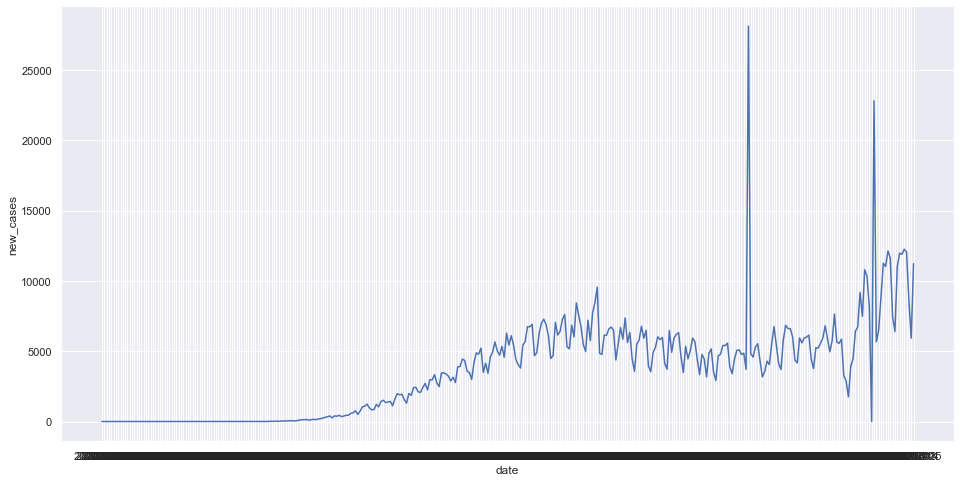

In [5]:
covid_mex = covid[covid["location"]=="Mexico"].fillna(0)
covid_mex = covid_mex.reset_index(drop=True)


covid_mex = covid_mex[['location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed']]

sns.set(rc={'figure.figsize':(16,8)})
sns.lineplot(data=covid_mex, x="date", y="new_cases")


There seems to be what appears to be at least two strange peaks, and one trough. Also form the plot we can see that there is a weekly seasonal behavior.

We will see what happens to this behavior after we "smooth" the data. For that we will take a 7 day rolling mean.

Also, we see that there is a variable in the data that is called "new_cases_smoothed". We will compare over 7 day rolling mean vs this column to validate that in fact there are the same.



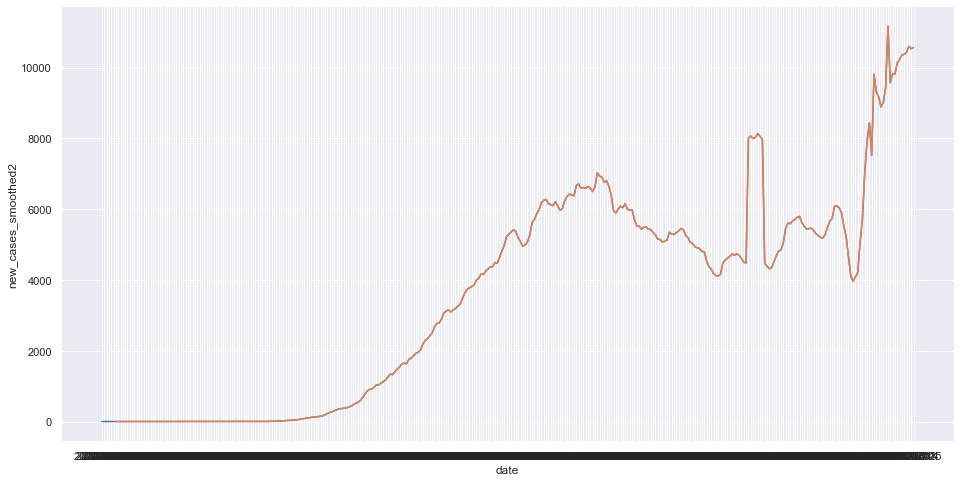

In [8]:
covid_mex["new_cases_smoothed2"] = covid_mex["new_cases"].rolling(7).mean()

sns.lineplot(data=covid_mex, x="date", y="new_cases_smoothed")
sns.lineplot(data=covid_mex, x="date", y="new_cases_smoothed2")

Both plots are exactly the same meaning we are right about the meaning of the smoothing column.

In the smooth plot we can see that one of the peaks disappear but not the other.

Can we find these anomalies automatically?
We will use an IsolationForest which is excellent at finding anomalies in a one dimensional array.


In [11]:
def find_and_plot_anomalies(covid_mex):
    #start Forest
    clf=IsolationForest(n_estimators=100, contamination=float(.01), bootstrap = False)
    #fit data
    clf.fit(covid_mex[['new_cases']])
    #predict anomalies
    covid_mex['anomaly']=clf.predict(covid_mex[['new_cases']])
    
    #change the values so anomalies are labled "1"
    covid_mex.loc[covid_mex['anomaly'] == 1,'anomaly'] = 0
    covid_mex.loc[covid_mex['anomaly'] == -1,'anomaly'] = 1 
    
    #find the anomalies
    anom = covid_mex.loc[covid_mex['anomaly'] == 1, ['date', 'new_cases']] 

    #plot new cases in a line and anomalies as red dots
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(covid_mex['date'], covid_mex['new_cases'], color='blue', label = 'Normal')
    ax.scatter(anom['date'],anom['new_cases'], color='red', label = 'Anomaly')
    return covid_mex

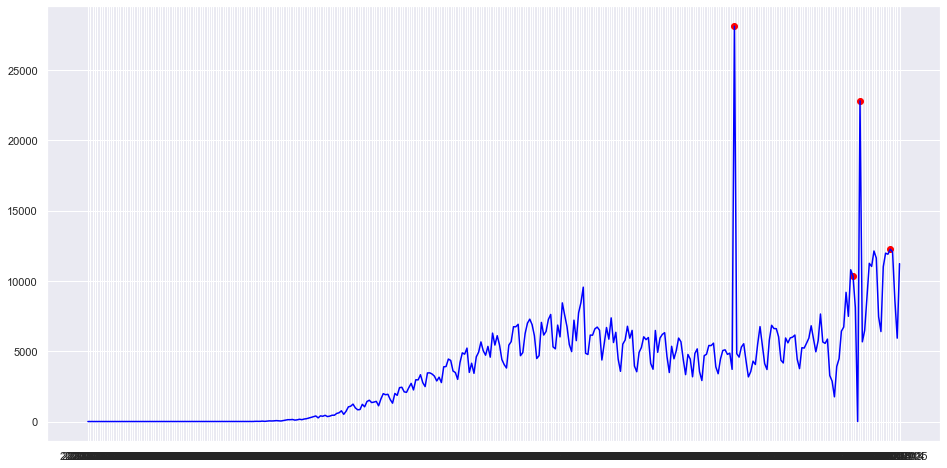

In [12]:
#find anomalies for all dates
covid_mex = find_and_plot_anomalies(covid_mex)

<ipython-input-11-f380e76481ec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_mex['anomaly']=clf.predict(covid_mex[['new_cases']])
C:\Users\wegma\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


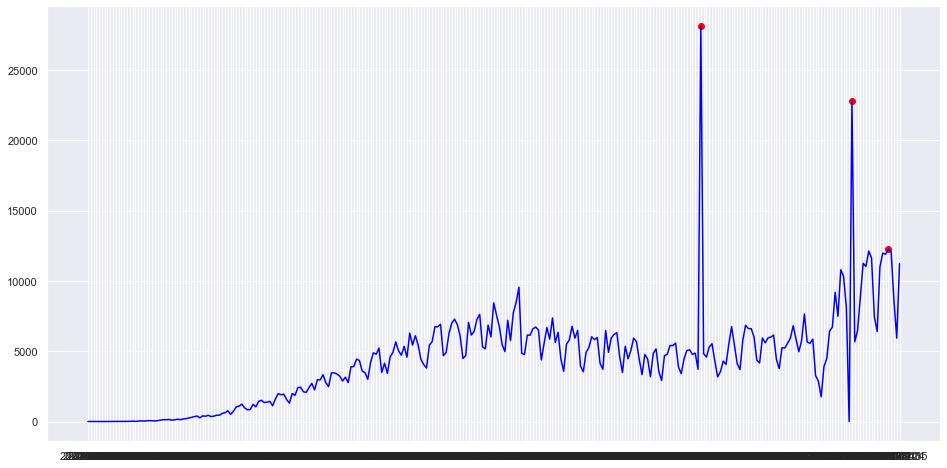

In [14]:
#It finds the two big peaks, plus some else.. but not the trough with a value of zero.

#let´s try to find the anomalies if we only takes dates stating from the first reported case.

first_case = covid_mex["new_cases"].ne(0).idxmax()
covid_mex_2 = covid_mex[covid_mex.index>=first_case]

covid_mex_2 =find_and_plot_anomalies(covid_mex_2)

<ipython-input-11-f380e76481ec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_mex['anomaly']=clf.predict(covid_mex[['new_cases']])
C:\Users\wegma\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


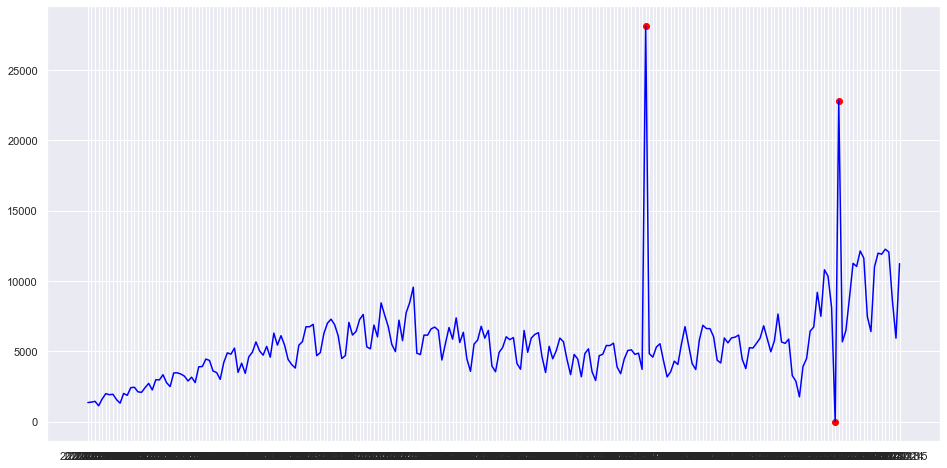

In [15]:
#Still no trough

#What if we start the plot in a date when there were more cases. We will use may 1st.

covid_mex_3 =  covid_mex[covid_mex["date"]> "2020-05-01"]
covid_mex_3 = find_and_plot_anomalies(covid_mex_3)

We found what we are looking for!!!

We can conclude that the reason the algorithm was not finding the trough was because there were too many days with zero cases at the beginning of the pandemic in Mexico.

The next step is to get rid of these three anomalies.

In [16]:
covid_mex_3[covid_mex_3["anomaly"]==1]

,location,date,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed2,anomaly
278,Mexico,2020-10-05,789780.0,28115.0,8009.000,8009.000000,1
331,Mexico,2020-11-27,1078594.0,0.0,7517.857,7517.857143,1
332,Mexico,2020-11-28,1101403.0,22809.0,9816.429,9816.428571,1


It's clear that the anomalies for Nov 27-28th were caused by a simple error: the new cases for one day were not reported and the sum of both days together were reported in one day.

For these two we will substitute the value of both days for their average.

In [17]:
num_to_sub = (covid_mex.loc[331, "new_cases"] + covid_mex.loc[332, "new_cases"])/2
#sustitute for the avergae of both days
covid_mex.loc[331, "new_cases"] = num_to_sub
covid_mex.loc[332, "new_cases"] = num_to_sub

In the other case, we checked the news, and the anomaly peak is given by a readjustment of the numbers by the government.
For this anomaly we will substitute for the day after (We don't do the average of days before and after because Sunday cases are underrepresented, as we will see soon)

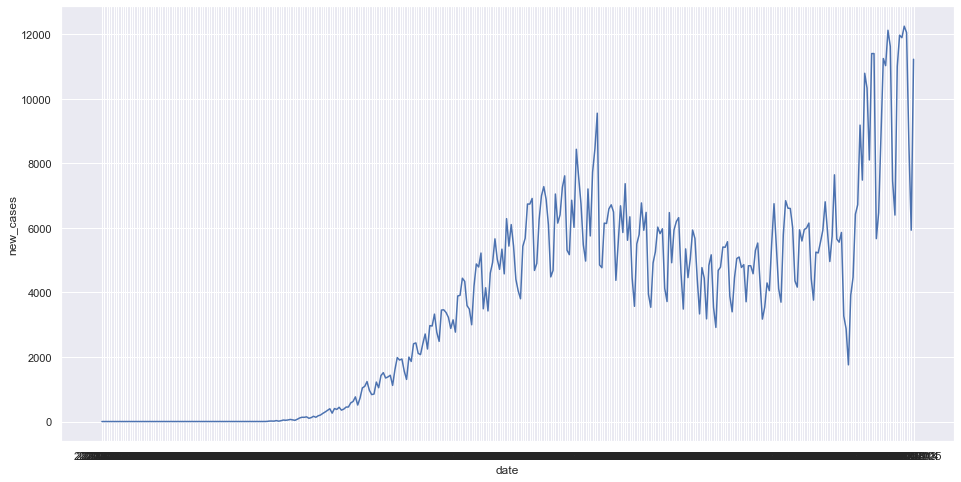

In [18]:
covid_mex.loc[278, "new_cases"] = covid_mex.loc[279, "new_cases"]

#lets plot and see if the peaks dissapeared
sns.lineplot(data=covid_mex, x="date", y="new_cases")

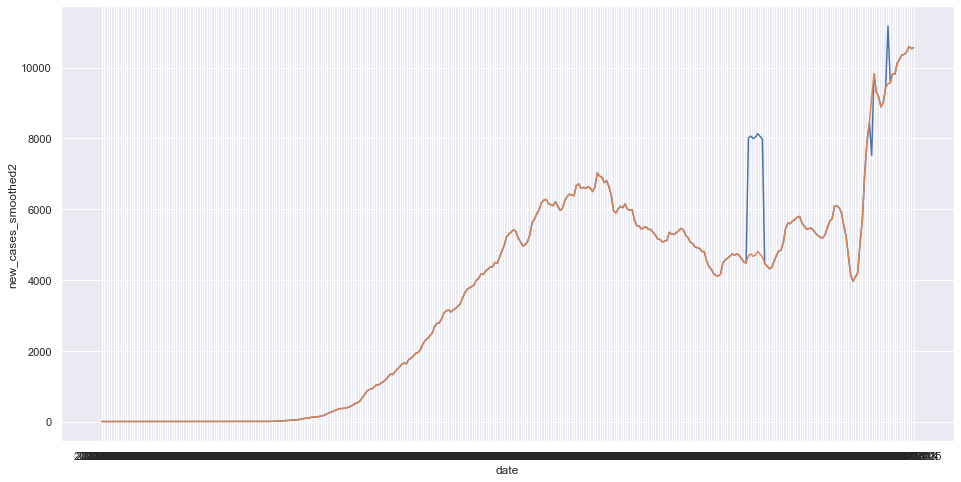

In [19]:
# Seems the anomalies are not there anymore.
# Now we can resmooth the data,
covid_mex["new_cases_smoothed2"] = covid_mex["new_cases"].rolling(7).mean()
#change the NA from the first 6 days to zero.
covid_mex["new_cases_smoothed2"] = covid_mex["new_cases_smoothed2"].fillna(0)

sns.lineplot(data=covid_mex, x="date", y="new_cases_smoothed")
sns.lineplot(data=covid_mex, x="date", y="new_cases_smoothed2")

In [20]:
print(covid_mex["date"].dtype)

covid_mex["date"]= pd.to_datetime(covid_mex["date"])

print(covid_mex["date"].dtype)

covid_mex["date_day_week"] = covid_mex["date"].dt.day_name()

covid_mex.head()

object
datetime64[ns]


,location,date,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed2,anomaly,date_day_week
0,Mexico,2020-01-01,0.0,0.0,0.0,0.0,0,Wednesday
1,Mexico,2020-01-02,0.0,0.0,0.0,0.0,0,Thursday
2,Mexico,2020-01-03,0.0,0.0,0.0,0.0,0,Friday
3,Mexico,2020-01-04,0.0,0.0,0.0,0.0,0,Saturday
4,Mexico,2020-01-05,0.0,0.0,0.0,0.0,0,Sunday


Looks like the date was not in datetime form (BTW this is the reason in the previous plots the x-axis did not have clear labels.

Let’s use data starting the first case and plot the mean of the cases per day of the week.

Text(0, 0.5, 'Mean new cases')

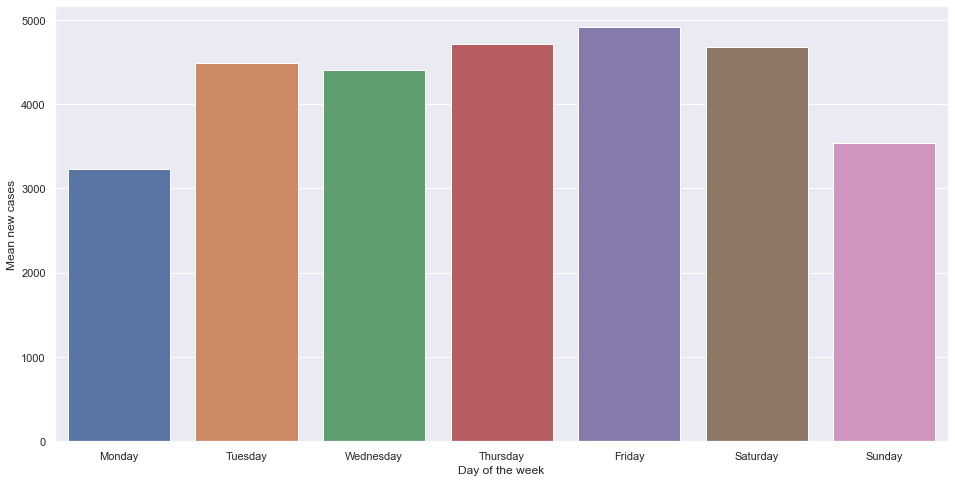

In [27]:
first_case = covid_mex["new_cases"].ne(0).idxmax()
covid_mex_2 = covid_mex[covid_mex.index>=first_case]

day_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day_of_week_cases = covid_mex_2.groupby(["date_day_week"]).mean()["new_cases"].reset_index()
sns.barplot(x="date_day_week", y="new_cases", data=day_of_week_cases,  order=day_of_week_order)
plt.xlabel('Day of the week')
plt.ylabel('Mean new cases')



Looks like Sunday and Monday might be different from the other days. Let's have a better comparison using a boxplot.


Text(0, 0.5, 'New cases')

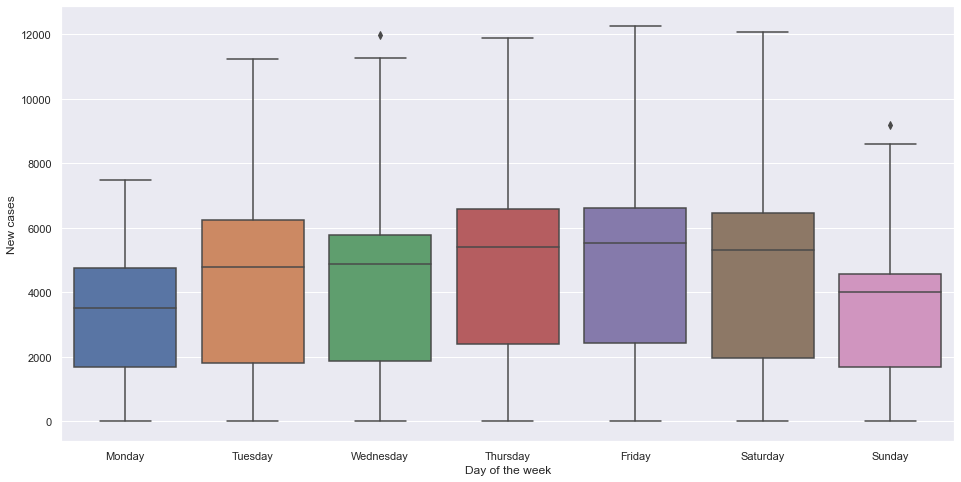

In [28]:
sns.boxplot(x="date_day_week", y="new_cases", data=covid_mex_2,
            order=day_of_week_order)
plt.xlabel('Day of the week')
plt.ylabel('New cases')


If we look at the first value of the third quartile for Sunday and Monday. It does look like it is below the median of the other days. This gives a strong indication that these days might have different distributions.

Let´s plot the distribution for all days of the week and see how they look.

Text(0, 0.5, 'Density')

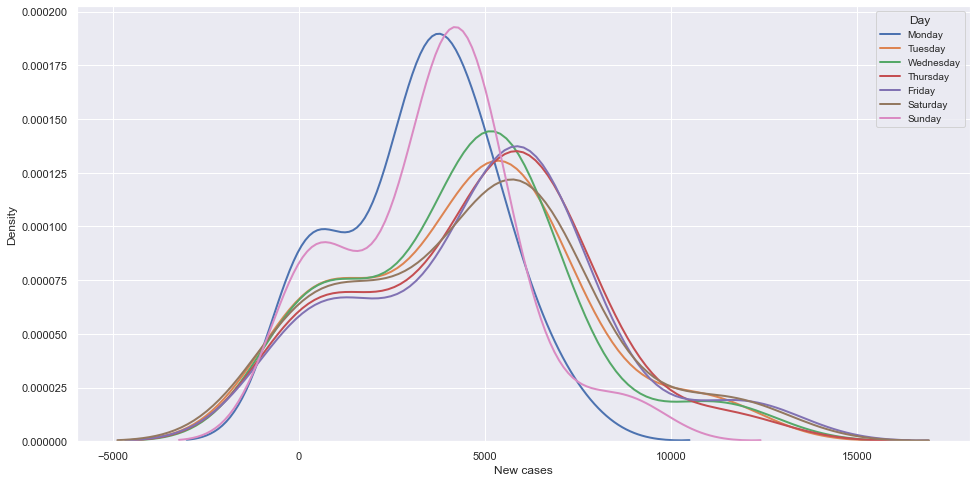

In [29]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


for day in days_of_week:
    cases = covid_mex_2[covid_mex_2['date_day_week'] == day]
    sns.distplot(cases['new_cases'], 
                 hist = False,
                 kde_kws = {'linewidth': 2},
                 label = day)
    
plt.legend(prop={'size': 10}, title = 'Day')
plt.xlabel('New cases')
plt.ylabel('Density')

Let´s calculate the p-value for the t-test, that the mean for each day of the week is in fact different.

In [30]:
p_val = []
for day1 in days_of_week:
    for day2 in days_of_week:

        cases1 = covid_mex_2[covid_mex_2['date_day_week'] == day1]["new_cases"]
        cases2 = covid_mex_2[covid_mex_2['date_day_week'] == day2]["new_cases"]
        t, p = stats.ttest_ind(cases1,cases2)
        p_val.append((day1,day2,p))


p_val_df = pd.DataFrame(p_val, columns = ["day1", "day2", "p_value"])

p_val_df = p_val_df.pivot(index="day1",  columns ="day2", values = "p_value")
p_val_df

day2,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
day1,,,,,,,
Friday,1.000000,0.004869,0.739096,0.025658,0.775059,0.533281,0.450600
Monday,0.004869,1.000000,0.015875,0.511290,0.009242,0.028209,0.038271
Saturday,0.739096,0.015875,1.000000,0.065532,0.953611,0.780549,0.683469
Sunday,0.025658,0.511290,0.065532,1.000000,0.046087,0.109571,0.141424
Thursday,0.775059,0.009242,0.953611,0.046087,1.000000,0.727540,0.629043
Tuesday,0.533281,0.028209,0.780549,0.109571,0.727540,1.000000,0.894778
Wednesday,0.450600,0.038271,0.683469,0.141424,0.629043,0.894778,1.000000


With a 95% confidence we can say that the mean from Monday is different from the mean of all other days (excluding Sunday).
We can also say that Sunday is different from Friday and Thursday. 

Although with a little less confidence we can say that in fact Monday and Sunday are different from the other days.

## Predictions

For the next part of the analysis we will make some predictions.
To do that first we will look at the data and  check if it's stationary.

From this point on we will use the smoothed data to avoid the extra information given by the weekly seasonality of the data.

Also, we use the data that starts with the first confirmed case.

To check if the data is stationary we will use the adfuller algorithm and look for P-values less than 0.05.

In [31]:
#Original data
AF= adfuller(covid_mex["new_cases_smoothed2"], autolag='AIC')
stats_AF = pd.Series(AF[0:2], index=['Test Statistic','p-value'])
print("original data:")
print(stats_AF)

#diff once
AF= adfuller(covid_mex["new_cases_smoothed2"].diff().fillna(0), autolag='AIC')
stats_AF = pd.Series(AF[0:2], index=['Test Statistic','p-value'])
print("differentiate once:")
print(stats_AF)


#diff twice
AF= adfuller(covid_mex["new_cases_smoothed2"].diff().diff().fillna(0), autolag='AIC')
stats_AF = pd.Series(AF[0:2], index=['Test Statistic','p-value'])
print("differentiate twice:")
print(stats_AF)

#Dtat starts with the the first case.

first_case = covid_mex["new_cases"].ne(0).idxmax()
covid_mex_2 = covid_mex[covid_mex.index>=first_case]
covid_mex_3 =  covid_mex[covid_mex["date"]> "2020-05-01"]

#Original data
AF= adfuller(covid_mex_2["new_cases_smoothed2"], autolag='AIC')
stats_AF = pd.Series(AF[0:2], index=['Test Statistic','p-value'])
print("from first case data:")
print(stats_AF)

#diff once
AF= adfuller(covid_mex_2["new_cases_smoothed2"].diff().fillna(0), autolag='AIC')
stats_AF = pd.Series(AF[0:2], index=['Test Statistic','p-value'])
print("From first case data, differentiate once:")
print(stats_AF)


original data:
Test Statistic    0.064544
p-value           0.963555
dtype: float64
differentiate once:
Test Statistic   -2.943478
p-value           0.040521
dtype: float64
differentiate twice:
Test Statistic   -8.530368e+00
p-value           1.041651e-13
dtype: float64
from first case data:
Test Statistic   -0.453597
p-value           0.900758
dtype: float64
From first case data, differentiate once:
Test Statistic   -3.416394
p-value           0.010413
dtype: float64


Given that the p-value is above 0.05 we conclude that the data is not stationary in its original form, but becomes stationary after differentiate.
The p value is also lower if we start with the first case, so that is what we will do.


Let´s aslo look at the same calulation but assuming different trends.

From the documentation:
Constant and trend order to include in regression.
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“nc” : no constant, no trend.

In [65]:
res = sm.tsa.adfuller(covid_mex_2["new_cases_smoothed2"].diff().fillna(0),regression='c')
print('p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(covid_mex_2["new_cases_smoothed2"].diff().fillna(0),regression='ct')
print('p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(covid_mex_2["new_cases_smoothed2"].diff().fillna(0),regression='ctt')
print('p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(covid_mex_2["new_cases_smoothed2"].diff().fillna(0),regression='nc')
print('p-value:{}'.format(res[1]))


p-value:0.010742839393023361
p-value:0.04877197090522159
p-value:0.08523872516103376
p-value:0.0025259597014619796


In [32]:
#Seems our data has no trend or constant.

#lets look for the best values for p and q.
resDiff = sm.tsa.arma_order_select_ic(covid_mex_2["new_cases_smoothed2"].diff().fillna(0), max_ar=15, max_ma=15, ic='aic', trend='nc')
print('(p,q) =',resDiff['aic_min_order'])


C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Us

(p,q) = (6, 14)


C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Seems the best values are (p,q) = (6, 14).

Can we see this in the acf pacf plots?

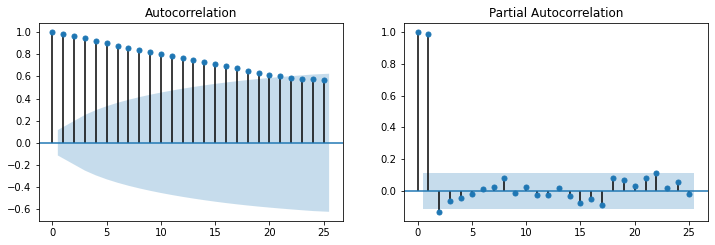

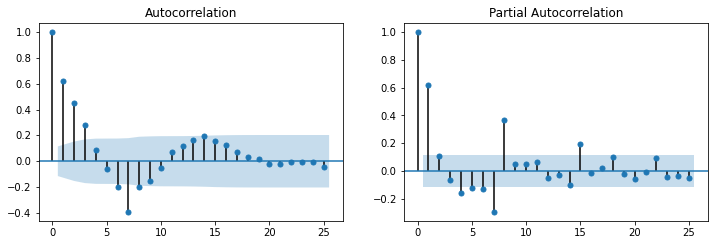

In [70]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(covid_mex_2["new_cases_smoothed2"], ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(covid_mex_2["new_cases_smoothed2"], ax=ax2) # using default value of lag



fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(covid_mex_2["new_cases_smoothed2"].diff().fillna(0), ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(covid_mex_2["new_cases_smoothed2"].diff().fillna(0), ax=ax2) # using default value of lag


C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


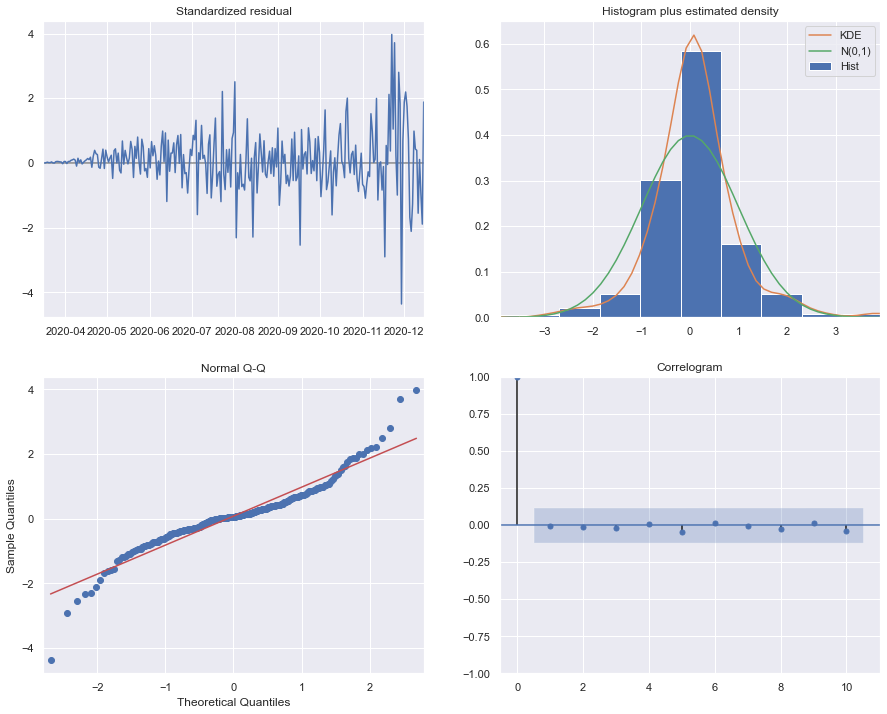

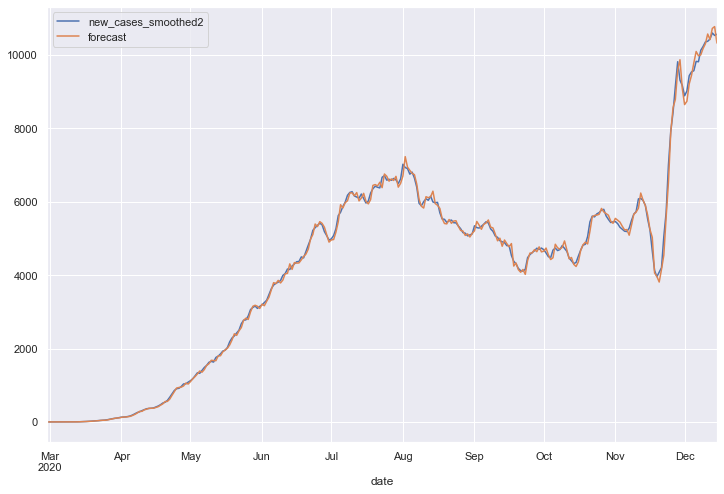

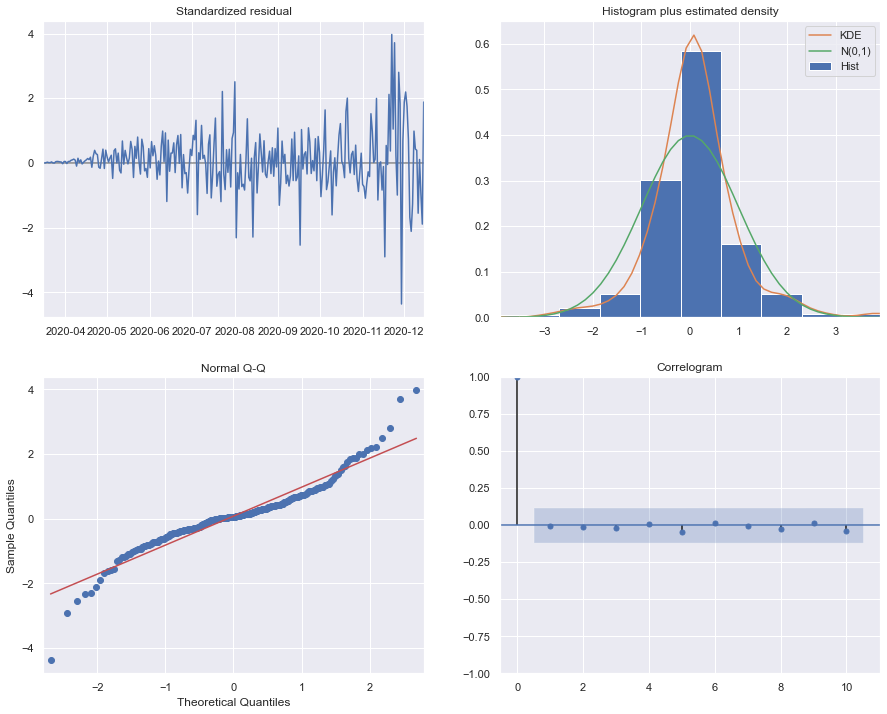

In [45]:
#The plots look closer to p,q  = 8, 16... not too far from the previous result.


model_data = covid_mex_2[["date","new_cases_smoothed2"]]
model_data = model_data.set_index("date")

#SARIMAX order (p,d,q) 
sarimax_mod = sm.tsa.statespace.SARIMAX(model_data["new_cases_smoothed2"],
                                        order=(6,1,14),
                                        seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False).fit()

#we use the season order (0,0,0,0) since there is no sesonality and we convert this to an ARIMA.

start_index = model_data.index[0]
end_index = model_data.index[-1]

#adding forecasted values and plotting
model_data['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,)  

model_data[start_index:][['new_cases_smoothed2', 'forecast']].plot(figsize=(12, 8))

#plot the diagnistics to see if the model is valid
sarimax_mod.plot_diagnostics(figsize=(15,12))

The residuals have a mean of zero, and the acf shows small residuals, this model seems to not have any hidden variables.

We will make a predictions for the next month.

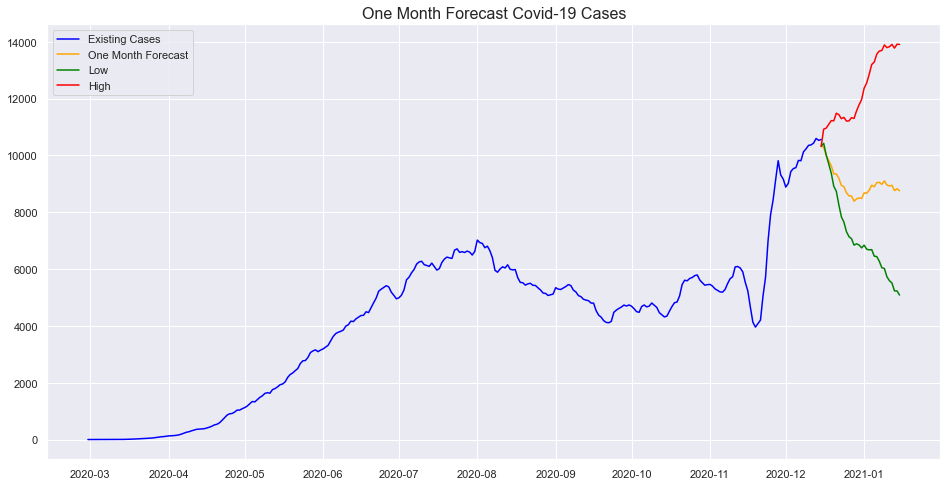

In [57]:
start_index = model_data.index[-1]
end_index = model_data.index[-1] + relativedelta(months=1)

#predict one month and get confident level
one_month_predict = sarimax_mod.predict(start= start_index ,end =end_index ,dynamic= True,)
forecast = sarimax_mod.get_forecast(end_index)

#use alpha=0.05 to get 95% confidence
forecast = forecast.conf_int(alpha=0.05)


predictions = pd.concat([one_month_predict, forecast], axis =1)
predictions.columns = ["pred", "lower", "higher"]

#the first value of the confidence level is NA, lets change it
predictions.loc[start_index, "lower"] = predictions.loc[start_index, "pred"] 
predictions.loc[start_index, "higher"] = predictions.loc[start_index, "pred"] 


fig = plt.figure(figsize=(16, 8))
plt.plot(model_data["new_cases_smoothed2"], color='blue', label='Existing Cases')
plt.plot(predictions['pred'], color='orange', label='One Month Forecast')
plt.plot(predictions['lower'], color='green', label='Low')
plt.plot(predictions['higher'], color='red', label='High')

plt.legend(loc='best')
plt.title('One Month Forecast Covid-19 Cases', size=16)
plt.show()

Yellow is the actual forecast, while red and green are the 95% confidence level.

To finish we will create a function so we can test the predictions at different times, the idea is that we can check if the model is actually accurate by comparing vs existing data.

In [58]:
def plot_model_predictions(start_index, end_index, order=(6,1,14)):
    model_data = covid_mex_2[["date","new_cases_smoothed2"]]
    model_data_2  = model_data[model_data["date"] < start_index]
    model_data_2 = model_data_2.set_index("date")
    model_data = model_data.set_index("date")


    #SARIMAX order (p,d,q) 

    sarimax_mod = sm.tsa.statespace.SARIMAX(model_data_2["new_cases_smoothed2"],
                                            order=order,
                                            seasonal_order=(0,0,0,0),
                                     enforce_stationarity=False).fit()

    #predict one month and get confident level
    one_month_predict = sarimax_mod.predict(start= start_index ,end =end_index ,dynamic= True,)
    forecast = sarimax_mod.get_forecast(end_index)

    #use alpha=0.05 to get 95% confidence
    forecast = forecast.conf_int(alpha=0.05)


    predictions = pd.concat([one_month_predict, forecast], axis =1)
    predictions.columns = ["pred", "lower", "higher"]

    #the first value of the confidence level is NA, lets change it
    predictions.loc[start_index, "lower"] = predictions.loc[start_index, "pred"] 
    predictions.loc[start_index, "higher"] = predictions.loc[start_index, "pred"] 

    fig = plt.figure(figsize=(16, 8))
    plt.plot(model_data["new_cases_smoothed2"], color='blue', label='Existing Cases')

    plt.plot(predictions['pred'], color='orange', label='One Month Forecast')
    plt.plot(predictions['lower'], color='green', label='Low')
    plt.plot(predictions['higher'], color='red', label='High')

C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


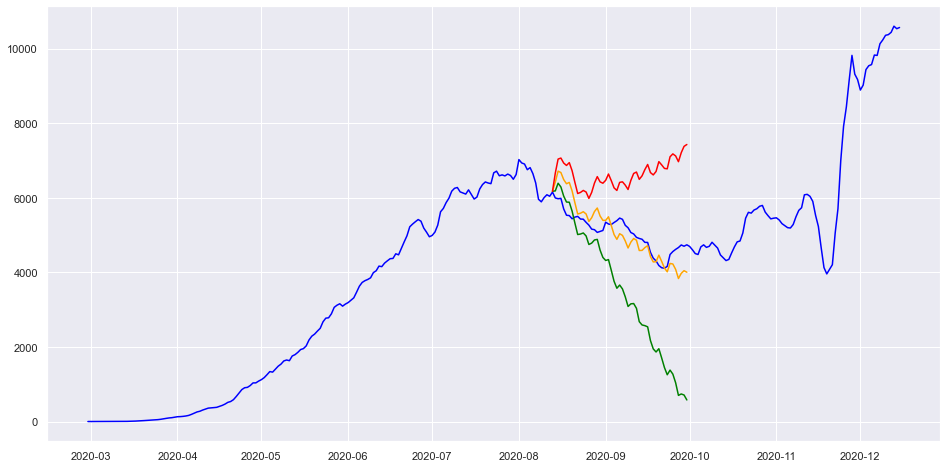

In [62]:
start_index = '2020-08-13'
end_index = '2020-9-30'
plot_model_predictions(start_index, end_index)

The prediction looks accurate enough for at least a month and a half after the starting point of the prediction.

C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


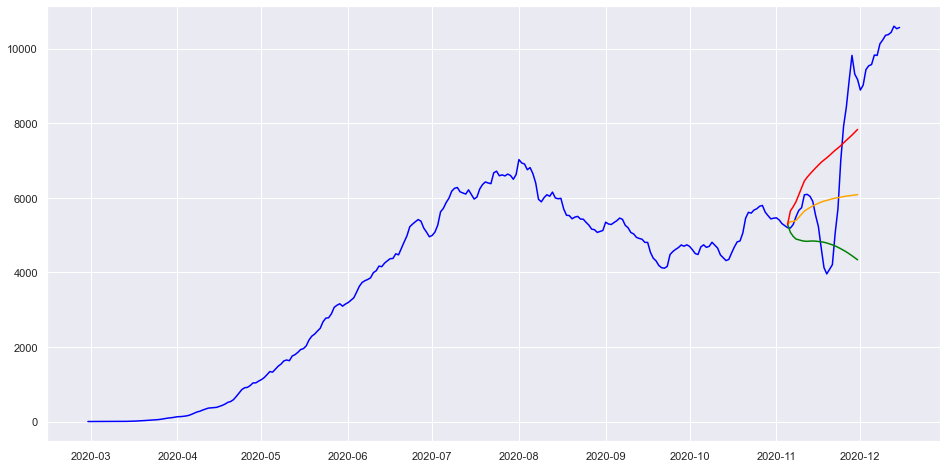

In [64]:
start_index = '2020-11-05'
end_index = '2020-11-30'
plot_model_predictions(start_index, end_index)

C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


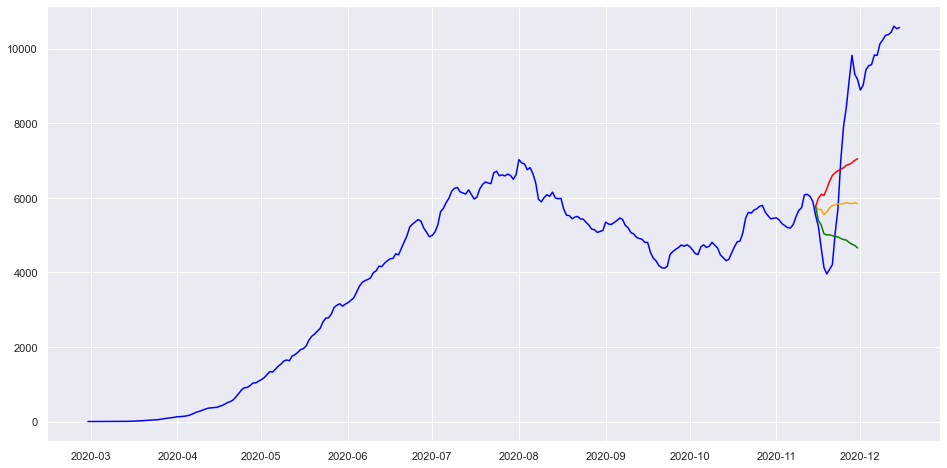

In [65]:
start_index = '2020-11-15'
end_index = '2020-11-30'
plot_model_predictions(start_index, end_index)

C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\wegma\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


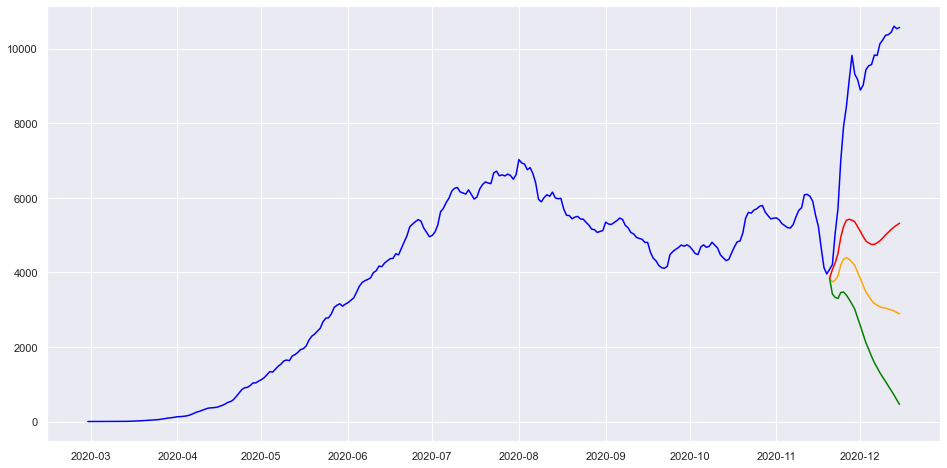

In [67]:
start_index = '2020-11-20'
end_index = '2020-12-15'
plot_model_predictions(start_index, end_index)

## Conclusions:

The model seems to work well enough considering that it uses only one variable to make the prediction.  We would expect much better results using a model that considers other conditions, for example lockdown severity and number of tests.
